# Advanced Units - Advanced Deep Learning

In [1]:
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset,ChainDataset
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import urllib.request
import zipfile
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
torch.cuda.is_available()
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cuda.matmul.allow_tf32 = False

torch.cuda.empty_cache()
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

if cuda_available:
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print("CUDA version:", cuda_version)

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


In [2]:
def load_images_from_folder_gpu(folder, target_resolution=(128, 128)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images = []
    transform = transforms.Compose([
        transforms.Resize(target_resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ])

    file_list = sorted([filename for filename in os.listdir(folder) if filename.endswith(".jpg") or filename.endswith(".jpeg")])
    progress_bar = tqdm(total=len(file_list), desc=f'Loading images from {folder}', unit='image')
    for filename in file_list:
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB') 
        img = transform(img).to(device)
        if img.shape == torch.Size([3, 128, 128]):
            images.append(img)
        progress_bar.update(1)

    progress_bar.close()
    return images

folder1 = "images"
folder2 = "distorted"

start_time = time.time()

with ThreadPoolExecutor() as executor:
    future1 = executor.submit(load_images_from_folder_gpu, folder1)
    future2 = executor.submit(load_images_from_folder_gpu, folder2)
    
    images1 = future1.result()
    images2 = future2.result()

end_time = time.time()
processing_time = end_time - start_time

print(f"Processing time: {processing_time} seconds")
print(f"Number of images in folder1: {len(images1)}")
print(f"Number of images in folder2: {len(images2)}")

data = [(img1, img2) for img1, img2 in zip(images1, images2)]


Loading images from distorted:   0%|          | 0/2405 [00:00<?, ?image/s]

Loading images from images:   0%|          | 0/2405 [00:00<?, ?image/s]

Processing time: 216.65853881835938 seconds
Number of images in folder1: 2405
Number of images in folder2: 2405


In [3]:
# print(type(data))

In [4]:
image1, image2 = data[0]

In [5]:
# print(image1)

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 64
# Define data augmentation transformations
transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.7),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(70),
])

augmented = []
for img1, img2 in data:
    augmented_img1 = transformation(img1)
    augmented_img2 = transformation(img2)
    augmented.append((augmented_img1, augmented_img2))

concatenated_data = data + augmented

train_ratio = 0.8  # 80% of the data for training, 20% for testing
val_ratio = 0.1  # 10% of the data for validation

total_samples = len(concatenated_data)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    concatenated_data, [train_size, val_size, test_size]
)

# Create DataLoaders for the train, validation, and test datasets
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    drop_last=True,
)

val_data_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=True,
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=True,
)

In [7]:
len(concatenated_data[0])

2

In [8]:
type(concatenated_data[0])

tuple

In [9]:
tuple_item = concatenated_data[0]

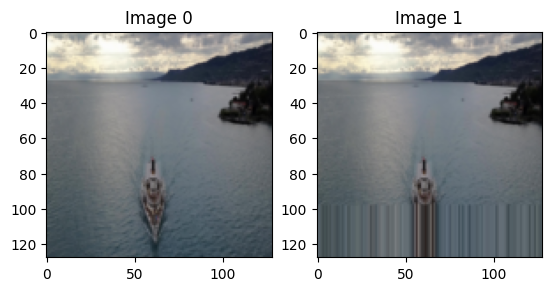

In [10]:
tuple_item = concatenated_data[0]

image_0 = tuple_item[0].cpu().numpy().transpose(1, 2, 0)
image_1 = tuple_item[1].cpu().numpy().transpose(1, 2, 0)

# Plot the first image
plt.subplot(1, 2, 1) 
plt.imshow(image_0) 
plt.title('Image 0')  

# Plot the second image
plt.subplot(1, 2, 2)   
plt.imshow(image_1) 
plt.title('Image 1')  

plt.show() 


In [11]:
# Create an iterator from the train_data_loader
train_iterator = iter(test_data_loader)

# Get the next batch
batch = next(train_iterator)

# Check the size of the batch
batch_size = len(batch[0])
print("Batch size:", batch_size)

Batch size: 64


In [12]:
len(train_data_loader)

60

In [13]:
len(train_dataset)

3848

In [14]:
# for batch in train_data_loader:
#     for item in batch:
#         item_size = item.size()
#         print(f"Item size: {item_size}")

In [15]:
# Set random seed for reproducibility
torch.manual_seed(42)

class VAEWithAttention(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, enkernel_size, enstride, enpadding):
        super(VAEWithAttention, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, output_dim, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.4),
            nn.BatchNorm2d(output_dim),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim, output_dim*2, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.4),
            nn.BatchNorm2d(output_dim*2),
            nn.LeakyReLU(),

            nn.Conv2d(output_dim*2, output_dim*4, kernel_size=enkernel_size, stride=enstride, padding=enpadding),
            nn.Dropout(0.3),
            nn.BatchNorm2d(output_dim*4),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear((output_dim)*(output_dim)*(output_dim), hidden_dim),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, latent_dim*2),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, 256 * 8 * 8),
            nn.Unflatten(1, (256, 8, 8)),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.4),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )



    def encode(self, x):
        encoded = self.encoder(x)
        mean = encoded[:, :latent_dim]
        logvar = encoded[:, latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)     
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# # Reconstruction loss
# def reconstruction_loss(x, x_hat):
#     return nn.MSELoss()(x_hat, x)

# Regularization loss (KL divergence)
# def kl_divergence_loss(mean, logvar):
#     kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     return kl_loss

# Apply denoising techniques (example: Gaussian noise)
def apply_noise(images, std_dev):
    noise = torch.randn_like(images) * std_dev
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0, 1)
    return noisy_images


In [16]:
epochs = 200
learning_rate = 1e-3
latent_dim = 300
hidden_dim = 300
output_dim = 32
enkernel_size =3
enstride= 2
enpadding =1

# # test model 
# # Create an instance of the VAEWithAttention model
# model = VAEWithAttention(latent_dim, hidden_dim, output_dim, enkernel_size, enstride,enpadding )

# # Input tensor for debugging
# input_tensor = torch.randn(2, 3, 128, 128)  # Adjust the shape according to your input size
# input_tensor_decoder = torch.randn(2, 256)

# with torch.no_grad():
#     for name, module in model.named_children():
#         if isinstance(module, nn.Sequential) and name.startswith('encoder'):
#             output = input_tensor
#             for sub_module in module:
#                 output = sub_module(output)
#                 print(f"{name} output size:", output.size())
#         elif isinstance(module, nn.Sequential) and name.startswith('decoder'):     
#             output = input_tensor_decoder
#             for sub_module in module:
#                 output = sub_module(output)
#                 print(f"{name} output size:", output.size())
#         else:
#             output = module(input_tensor)
#             print(f"{name} output size:", output.size())

# # Forward pass
# output, mean, logvar = model(input_tensor)

# # Print the shapes for debugging
# print("Input shape:", input_tensor.shape)
# print("Output shape:", output.shape)
# print("Mean shape:", mean.shape)
# print("Logvar shape:", logvar.shape)

In [17]:
vae = VAEWithAttention(latent_dim, hidden_dim, output_dim, enkernel_size, enstride,enpadding )

criterion = nn.L1Loss(reduction='sum')

# criterion = nn.MSELoss(reduction='mean')
#criterion = nn.BCELoss(reduction='none')
kl_weight = 1.0 

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [19]:
train_losses = []
val_losses = []  
test_losses = []  

vae.to(device)
vae.train()

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0

    for images in train_data_loader:
        images = images[0].to(device)
        noisy_images = apply_noise(images, std_dev=0.1).to(device)

        optimizer.zero_grad()
        reconstructed_images, mean, logvar = vae(noisy_images)

        recon_loss = criterion(reconstructed_images, images)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        #loss = recon_loss + kl_weight * kl_loss
        loss = recon_loss + kl_weight * kl_loss 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_data_loader.dataset)
    train_losses.append(average_loss)

    vae.eval()
    val_loss = 0

    with torch.no_grad():
        for images in val_data_loader:
            images = images[0].to(device)
            reconstructed_val_images, _, _ = vae(images)
            reconstruction_val_loss = criterion(reconstructed_val_images, images)
            val_loss += reconstruction_val_loss.mean().item()

    average_val_loss = val_loss / len(val_data_loader.dataset)
    val_losses.append(average_val_loss)

    scheduler.step(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

end_time = time.time()
processing_time = end_time - start_time
print(f"Processing time: {processing_time:.2f} seconds")

# Save the trained model
torch.save(vae.state_dict(), "vae_model.pth")




Epoch [1/200], Train Loss: 9161.0890, Validation Loss: 8901.8278
Epoch [11/200], Train Loss: 4951.5594, Validation Loss: 4543.8449
Epoch [21/200], Train Loss: 4596.1802, Validation Loss: 4337.3976
Epoch [31/200], Train Loss: 4295.0218, Validation Loss: 4152.8669
Epoch [41/200], Train Loss: 3977.3784, Validation Loss: 4092.9593
Epoch [51/200], Train Loss: 3674.7466, Validation Loss: 4128.0923
Epoch [61/200], Train Loss: 3349.5840, Validation Loss: 4075.3126
Epoch [71/200], Train Loss: 3286.3010, Validation Loss: 4087.6631
Epoch [81/200], Train Loss: 3277.7618, Validation Loss: 4088.1609
Epoch [91/200], Train Loss: 3275.4192, Validation Loss: 4092.5086
Epoch [101/200], Train Loss: 3277.7987, Validation Loss: 4086.7843
Epoch [111/200], Train Loss: 3275.6824, Validation Loss: 4085.6674
Epoch [121/200], Train Loss: 3277.3649, Validation Loss: 4084.3598
Epoch [131/200], Train Loss: 3277.5506, Validation Loss: 4084.7882
Epoch [141/200], Train Loss: 3276.7747, Validation Loss: 4082.4036
Epoch 

Test Loss: 571.1848
Test Loss: 1089.6761
Test Loss: 1672.2801
Test Loss: 2227.8478
Test Loss: 2761.5188
Test Loss: 3409.1620
Test Loss: 3985.7347


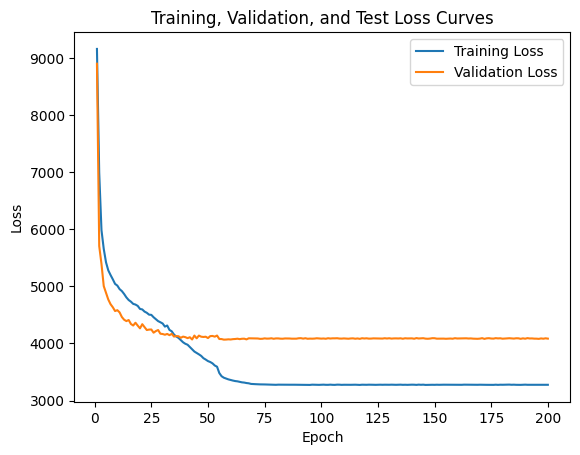

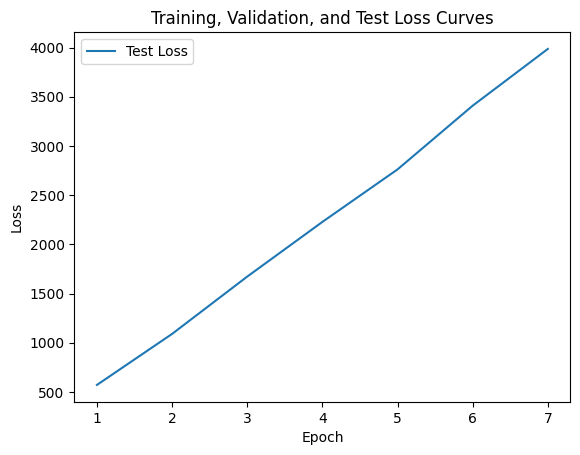

In [20]:
# Evaluation on test dataset
vae.eval()
test_loss = 0

with torch.no_grad():
    for images in test_data_loader:
        images = images[0].to(device)
        reconstructed_test_images, _, _ = vae(images)
        reconstruction_test_loss = criterion(reconstructed_test_images, images)
        test_loss += reconstruction_test_loss.mean().item()

        average_test_loss = test_loss / len(test_data_loader.dataset)
        test_losses.append(average_test_loss)
        print(f"Test Loss: {average_test_loss:.4f}")

plt.Figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.show()

plt.Figure()
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.show()



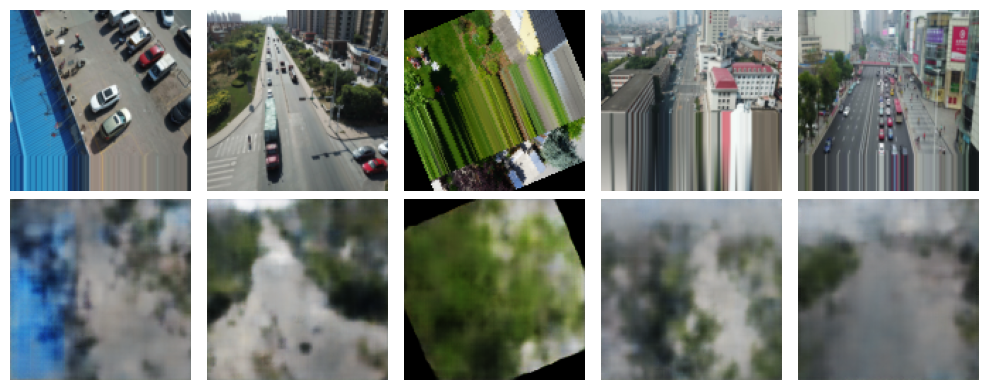

In [21]:
vae.eval()
with torch.no_grad():
    num_batches = 1  
    images_per_batch = 5  

    fig, axes = plt.subplots(nrows=2 * num_batches, ncols=images_per_batch, figsize=(10, 4 * num_batches))
    for batch_idx in range(num_batches):
        # Get a batch of images from the data loader
        images = next(iter(test_data_loader))
        images = images[1][:images_per_batch].to(device)  # Select the images from the batch

        reconstructed_images, _, _ = vae(images)

        for i in range(images_per_batch):
            axes[2 * batch_idx, i].imshow(images[i].permute(1, 2, 0).cpu())
            axes[2 * batch_idx, i].axis('off')
            axes[2 * batch_idx + 1, i].imshow(reconstructed_images[i].permute(1, 2, 0).cpu())
            axes[2 * batch_idx + 1, i].axis('off')

    plt.tight_layout()
    plt.show()


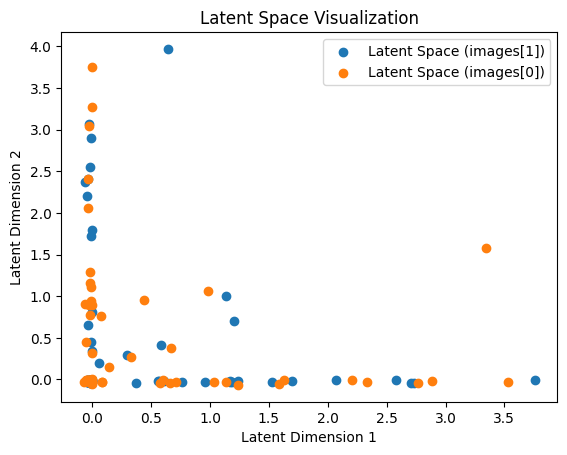

In [22]:
vae.eval()

with torch.no_grad():
    for images in test_data_loader:
        _, latent_means, _ = vae(images[1].to(device))
        _, latent_means0, _ = vae(images[0].to(device))

latent_means_cpu = latent_means.cpu().numpy()
latent_means0_cpu = latent_means0.cpu().numpy()

plt.scatter(latent_means_cpu[:, 0], latent_means_cpu[:, 1], label='Latent Space (images[1])')
plt.scatter(latent_means0_cpu[:, 0], latent_means0_cpu[:, 1], label='Latent Space (images[0])')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.show()



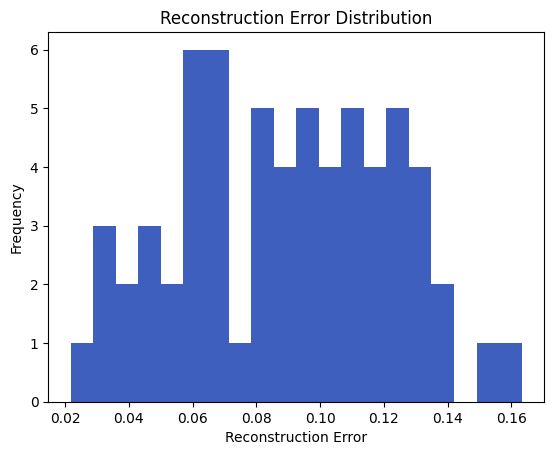

In [31]:
vae.eval()
with torch.no_grad():


    for images in test_data_loader:
        reconstructed_images, _, _ = vae(images[1].to(device))
        reconstructed_images0, _, _ = vae(images[0].to(device))
        
reconstruction_errors = torch.abs(reconstructed_images.cpu() - images[1].cpu())
reconstruction_errors = reconstruction_errors.view(reconstruction_errors.size(0), -1)
reconstruction_errors = torch.mean(reconstruction_errors, dim=1)

reconstruction_errors0 = torch.abs(reconstructed_images0.cpu() - images[0].cpu())
reconstruction_errors0 = reconstruction_errors.view(reconstruction_errors0.size(0), -1)
reconstruction_errors0 = torch.mean(reconstruction_errors0, dim=1)


plt.hist(reconstruction_errors.cpu().numpy(), bins=20, color='g', alpha= 0.5)
plt.hist(reconstruction_errors0.cpu().numpy(), bins=20, color='b', alpha =0.5)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.show()

In [26]:
vae.eval()
with torch.no_grad():

    for images in test_data_loader:
        reconstructed_images, _, _ = vae(images[0].to(device))

images_np = images[0].cpu().numpy()
reconstructed_images_np = reconstructed_images.cpu().numpy()

mse = mean_squared_error(images_np, reconstructed_images_np)
psnr = peak_signal_noise_ratio(images_np, reconstructed_images_np)
ssim = structural_similarity(images_np, reconstructed_images_np, win_size=3, channel_axis=0)

print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f}")
print(f"SSIM: {ssim:.4f}")



MSE: 0.0175
PSNR: 17.5670
SSIM: 0.6491
